# Clustering evaluation on high dimensional data

Here, we explore how the higher dimensional simplices are preserved within parts of a partition. We compare the number of simplices preserved in the ground truth partition with the number preserved via Leiden.

Surprisingly, although Leiden generally yields a larger partition size - so a finer partition - than the ground truth partition, it tends to preserve a larger number of simplices. This implies that Leiden's result is not a refinement of the ground truth: it groups points differently and preserves more of the simplices structure than the ground truth.

Moreover, the Leiden partition (obtained on the kNN in high dimension) also preserves more of the low-dimensional simplices than the ground-truth partition does.

We also plot cliques that are preserved by the graph clustering algorithm, not by the ground truth.

In [1]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [2]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn import cluster
from IPython.display import display, Markdown, Latex

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

import networkx as nx
import igraph as ig
import leidenalg as la
import cdlib.algorithms as cd
import itertools
import collections
import scipy

from community import community_louvain

sns.set()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'karateclub', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [3]:
## Assigns a ground_truth part to each clustering_labels part, or none. 
## It assigns whatever ground_truth part intersects with at least 50% of the clustering_labels part.
def mapping_partitions(ground_truth, clustering_labels):
    partition_mapping = []
    cl_max = np.max(clustering_labels)
    gt_max = np.max(ground_truth)
    for j in range(gt_max+1):
        for i in range(cl_max+1):       
            cl_indicator = (clustering_labels==i)
            gt_indicator = (ground_truth==j)
            if(sum(cl_indicator&gt_indicator) > 0.5*min(sum(cl_indicator), sum(gt_indicator))):
                partition_mapping.append((j,i))
    return(pd.DataFrame(partition_mapping, columns=['ground_truth', 'cluster']))

## Counts how many cliques of G of sizes 1,...,x are preserved within parts of the clustering_labels partition.
def clique_per_cluster(G, clustering_labels, x):
    cliques_part = []
    for d in range(np.max(clustering_labels)+1):
        sg = G.subgraph([i for i in range(G.vcount()) if clustering_labels[i]==d])
        cliques_part.append([len(sg.cliques(min=k,max=k)) for k in range(1, x+1)])
    res = pd.DataFrame(cliques_part, columns=[f'{str(i)}-clique' for i in range(1, x+1)])
    return(res)

def clique_preservation(G, ground_truth, clustering_labels, max_clique = 5):
    # Clique stats
    gt_stats = clique_per_cluster(G, ground_truth, x=max_clique)
    gt_summary = gt_stats.sum().reset_index(name='Count').rename(columns={'index': 'Structure'})
    gt_summary['Preserved in'] = 'Ground Truth'
    
    cl_stats = clique_per_cluster(G, clustering_labels, x=max_clique)
    cl_summary = cl_stats.sum().reset_index(name='Count').rename(columns={'index': 'Structure'})
    cl_summary['Preserved in'] = 'Leiden'
    
    all_summary = gt_summary.copy()
    all_summary['Count'] = [len(G.cliques(min=k,max=k)) for k in range(1, 5+1)]
    all_summary['Preserved in'] = 'All'
    all_summary['Structure'] = gt_summary.Structure
    
    clique_summary = pd.concat([all_summary, gt_summary, cl_summary])
    
    # Cluster mapping stats
    part_map = mapping_partitions(ground_truth, clustering_labels)
    clique_per_part = part_map.merge(cl_stats, left_on='cluster', right_index=True).merge(gt_stats, left_on='ground_truth', right_index=True, suffixes=('_cl', '_gt'))

    return(clique_per_part, clique_summary)  

In [4]:
# raw_data, targets, dataset_name = get_dataset(dataset_id)
# display(Markdown(f'## {dataset_name}'))
# G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
# G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
# umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2)

# ec = la.find_partition(G, la.ModularityVertexPartition)
# clustering_labels = np.array(ec.membership)
# G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

# ## q-based clustering
# if(verbose):
#     print('Ground truth: ')
#     print('size = ', max(targets)+1)
#     print('q = ',G.modularity(targets))
#     print('Leiden partition: ')
#     print('size = ', max(clustering_labels)+1)
#     print('q =',G.modularity(ec))
#     print('-----------------------')
#     print('ari =',adjusted_rand_score(targets,clustering_labels))
#     print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

# clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
# agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
# agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
# present_gt = np.isin(clustering_labels, list(agree_cl_gt.ground_truth))
# disagreement_labels = (agree_cl&present_gt)

# Pendigits - fuzzy union

In [5]:
dataset_id = 0
set_op_mix_ratio = 1
raw_data, targets, dataset_name, image_list = get_dataset(dataset_id, return_images=True)
display(Markdown(f'## {dataset_name}'))
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2, return_vectors=False)

## pendigits

In [6]:
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

In [7]:
## q-based clustering
print('Ground truth: ')
print('size = ', max(targets)+1)
print('q = ',G.modularity(targets))
print('Leiden partition: ')
print('size = ', max(clustering_labels)+1)
print('q =',G.modularity(ec))
print('-----------------------')
print('ari =',adjusted_rand_score(targets,clustering_labels))
print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

Ground truth: 
size =  10
q =  0.8424726535927892
Leiden partition: 
size =  12
q = 0.8601756688450055
-----------------------
ari = 0.882723265824925
ami = 0.9031742261305846


### Run the same analysis on all other datasets

In [9]:
def what_we_do_here(dataset_id, set_op_mix_ratio, verbose=True):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2, return_vectors=False)
    
    ec = la.find_partition(G, la.ModularityVertexPartition)
    clustering_labels = np.array(ec.membership)
    G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')
    
    ## q-based clustering
    if(verbose):
        print('Ground truth: ')
        print('size = ', max(targets)+1)
        print('q = ',G.modularity(targets))
        print('Leiden partition: ')
        print('size = ', max(clustering_labels)+1)
        print('q =',G.modularity(ec))
        print('-----------------------')
        print('ari =',adjusted_rand_score(targets,clustering_labels))
        print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

    clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
    agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
    agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
    present_gt = np.isin(clustering_labels, list(agree_cl_gt.ground_truth))
    disagreement_labels = (agree_cl&present_gt)
    return(G, umap_rep, clique_per_part, clique_summary,disagreement_labels)

In [10]:
dataset_id = 3
G, umap_rep, clique_per_part, clique_summary, disagreement_labels = what_we_do_here(dataset_id, 1.0)

## usps

Ground truth: 
size =  11
q =  0.8283499377845813
Leiden partition: 
size =  12
q = 0.8615405330502589
-----------------------
ari = 0.8029589472446911
ami = 0.8706883950364305


In [11]:
clique_summary

Structure  Count  Preserved in
0  1-clique   9298           All
1  2-clique  61633           All
2  3-clique  78517           All
3  4-clique  38572           All
4  5-clique   9639           All
0  1-clique   9298  Ground Truth
1  2-clique  57731  Ground Truth
2  3-clique  74417  Ground Truth
3  4-clique  36969  Ground Truth
4  5-clique   9308  Ground Truth
0  1-clique   9298        Leiden
1  2-clique  58351        Leiden
2  3-clique  75595        Leiden
3  4-clique  37756        Leiden
4  5-clique   9544        Leiden

<AxesSubplot:xlabel='Structure', ylabel='Count'>

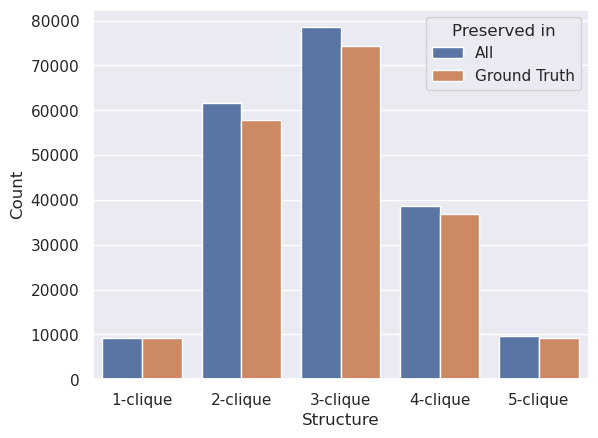

In [12]:
sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary[clique_summary['Preserved in']!='Leiden'])
# plt.savefig('figures/clique_preservation_groundTruth.png', bbox_inches='tight')

# Cliques in fuzzy union graph

## pendigits

Ground truth: 
size =  10
q =  0.8424726535927892
Leiden partition: 
size =  12
q = 0.8601756688450054
-----------------------
ari = 0.882723265824925
ami = 0.9031742261305846


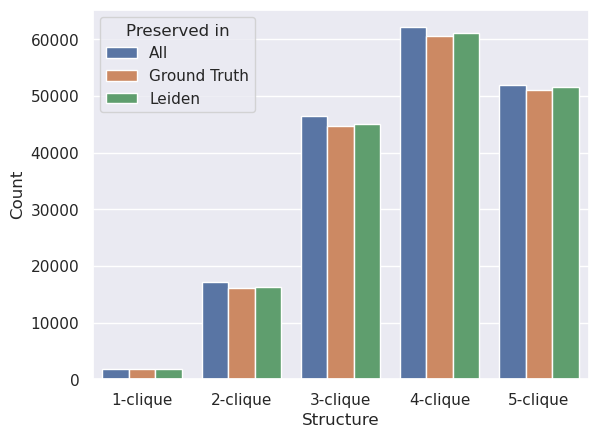

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        4          178         1796         4818         5532   
1              1        9          104          971         3191         5474   
2              1       10           80          652         2061         3590   
3              1       11           27          220          869         2011   
4              2        7          170         1513         4098         5605   
5              3        6          176         1599         4139         4923   
6              4        3          178         1628         4866         7352   
7              5        1          181         1636         4431         5655   
8              6        2          181         1687         4688         6244   
9              7        0          198         1826         5196         7398   
10             8        5          177         1456         3425         3696   
11             9        8          147         1331         3344         3709   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0          3331          178         1796         4818         5532   
1          5917          182         1619         5336         9483   
2          4034          182         1619         5336         9483   
3          3034          182         1619         5336         9483   
4          4839          177         1552         4197         5749   
5          3425          183         1628         4193         4974   
6          6644          181         1632         4868         7350   
7          4217          182         1626         4393         5614   
8          4999          181         1682         4673         6228   
9          6575          179         1674         4883         7057   
10         2317          174         1406         3316         3595   
11         2280          180         1521         3938         4956   

    5-clique_gt  
0          3331  
1         10834  
2         10834  
3         10834  
4          4963  
5          3446  
6          6643  
7          4207  
8          4992  
9          6319  
10         2266  
11         4071

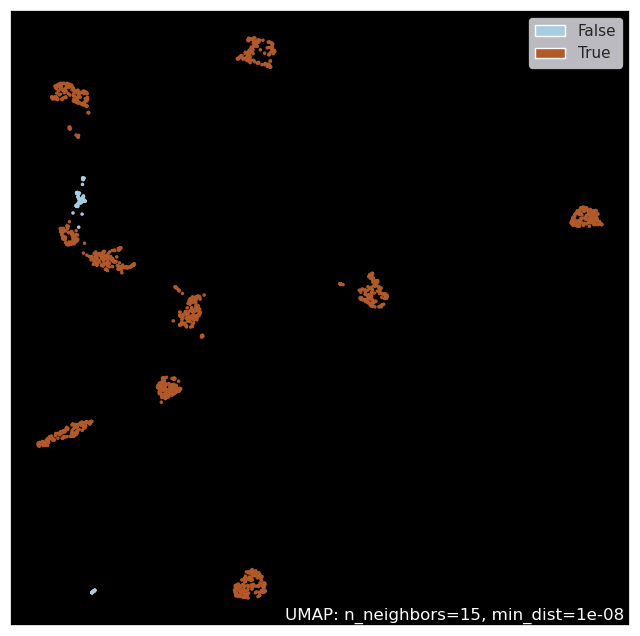

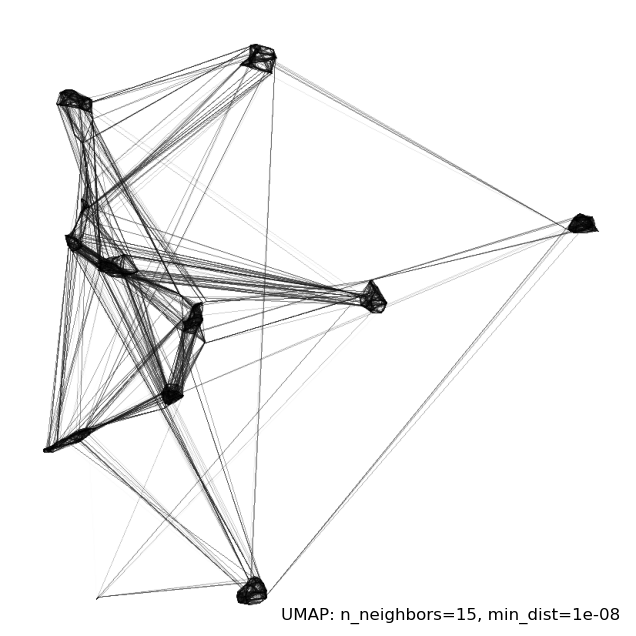

## coil

Ground truth: 
size =  21
q =  0.8945446658779549
Leiden partition: 
size =  26
q = 0.931580177412409
-----------------------
ari = 0.7498817591300243
ami = 0.8794887757702532


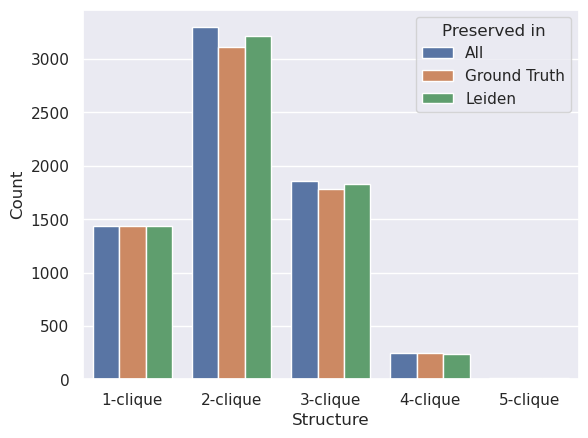

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        5           72          149           85            8   
1              2       12           65          143           87           11   
2              2       20           32           68           44            7   
3              4        9           72          148           80            4   
4              5       14           56          116           51            1   
5              7        0           94          198           95            8   
6              8       15           47           96           49            2   
7              9       19           34           79           44            3   
8              9       23           26           60           36            3   
9             10        3           72          145           74            1   
10            11        4           72          157           72            1   
11            12       10           72          178          119           20   
12            13       16           47          102           66           12   
13            13       24           25           54           39           11   
14            14        7           72          163           63            3   
15            15       18           43           95           64           13   
16            15       21           29           68           44            7   
17            16        6           72          178          129           25   
18            17       17           44          106           85           27   
19            17       22           28           64           49           13   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             0           72          149           85            8   
1             0           72          154           95           13   
2             0           72          154           95           13   
3             0           72          148           80            4   
4             0           72          143           53            1   
5             0           72          151           86            7   
6             0           72          150           82            7   
7             0           72          166           90            7   
8             0           72          166           90            7   
9             0           72          145           74            1   
10            0           72          157           72            1   
11            0           72          178          119           20   
12            1           72          156          105           23   
13            2           72          156          105           23   
14            0           72          163           63            3   
15            1           72          166          109           20   
16            0           72          166          109           20   
17            0           72          178          129           25   
18            3           72          174          134           40   
19            1           72          174          134           40   

    5-clique_gt  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11            0  
12            3  
13            3  
14            0  
15            1  
16            1  
17            0  
18            4  
19            4

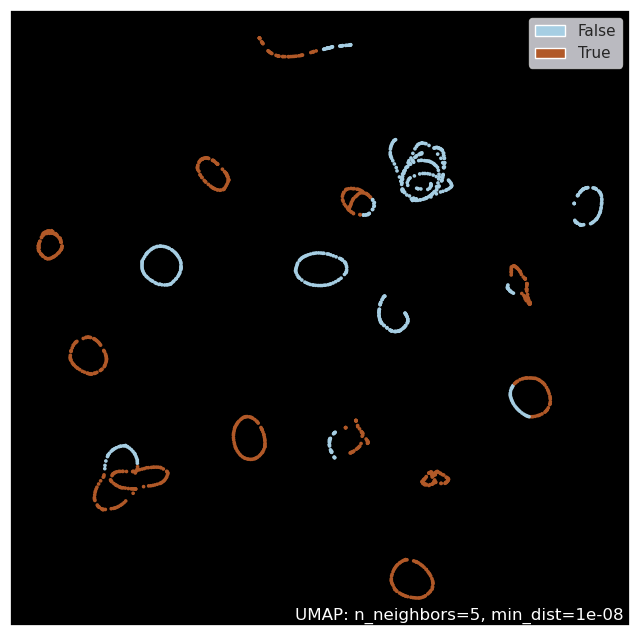

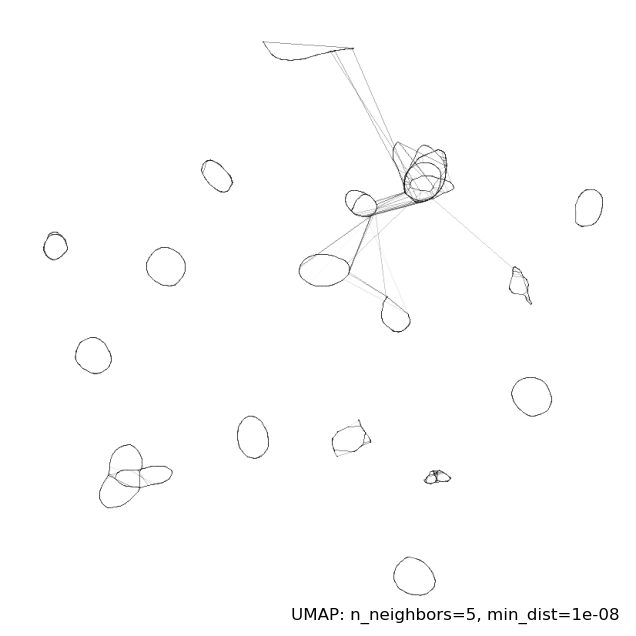

## mnist

Ground truth: 
size =  10
q =  0.828038492552303
Leiden partition: 
size =  13
q = 0.8586456983133856
-----------------------
ari = 0.8307717691285526
ami = 0.853480422775729


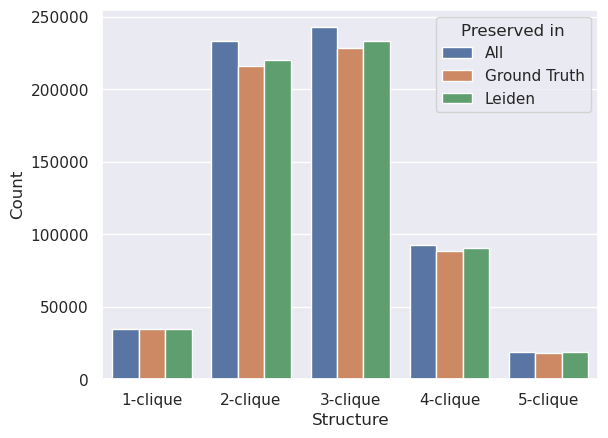

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        3         3493        22938        25764        10451   
1              1        8         2490        16128        21883        12484   
2              1       10         1757        11247        15952         9483   
3              2        4         3293        20221        19351         6272   
4              3        2         3516        22488        21547         6758   
5              4        5         3262        20216        20439         6987   
6              5        9         2258        13414        12368         3684   
7              5       11         1028         6281         6817         2602   
8              6        1         3538        22582        23502         8468   
9              7        0         3638        23473        25901        10121   
10             8        6         3053        18965        17375         5068   
11             9        7         2729        16663        16921         6078   
12             9       12          945         5488         5799         2276   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0          2029         3434        22422        25247        10284   
1          3965         4002        25997        36408        21313   
2          2959         4002        25997        36408        21313   
3           976         3434        20370        19324         6279   
4           922         3576        22202        21191         6667   
5          1116         3410        20619        20586         6975   
6           501         3150        19167        18525         5887   
7           476         3150        19167        18525         5887   
8          1496         3465        21901        22766         8206   
9          1838         3632        22871        25121         9807   
10          718         3373        19624        17692         5154   
11         1031         3524        21292        21923         8075   
12          452         3524        21292        21923         8075   

    5-clique_gt  
0          2008  
1          6749  
2          6749  
3          1009  
4           913  
5          1106  
6           805  
7           805  
8          1441  
9          1805  
10          744  
11         1432  
12         1432

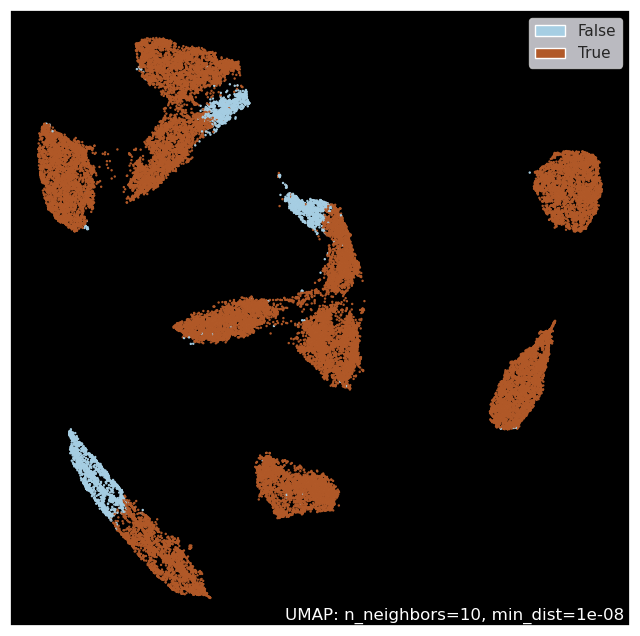

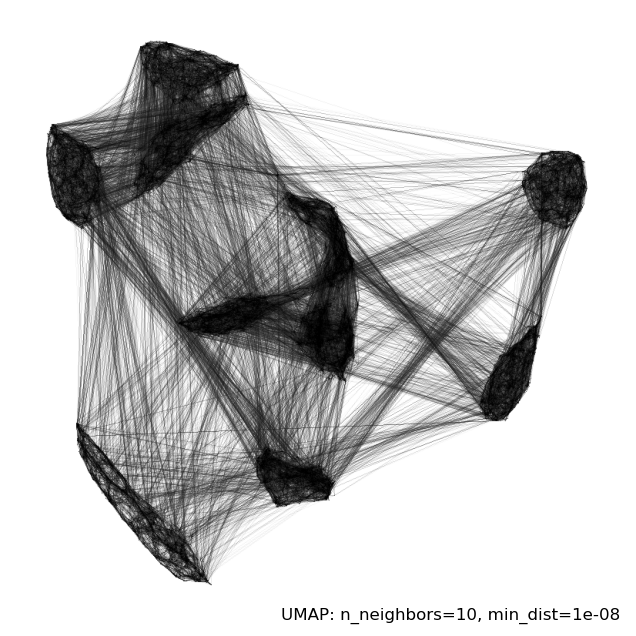

## usps

Ground truth: 
size =  11
q =  0.8283499377845813
Leiden partition: 
size =  12
q = 0.8613405441958131
-----------------------
ari = 0.7975349874900491
ami = 0.867033962608583


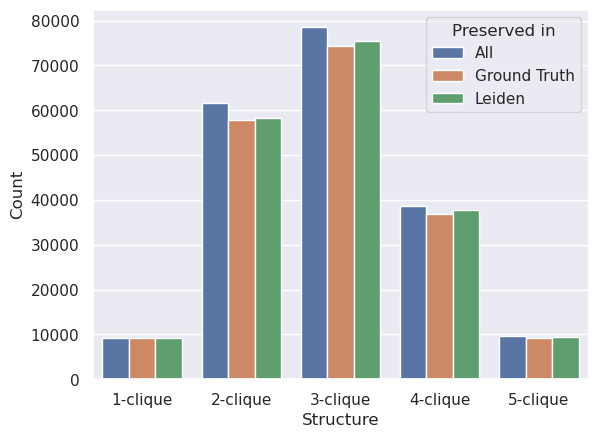

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        0          912         5788         7760         4008   
1              1       10          670         4217         5438         2505   
2              2        7          776         5022         7123         3900   
3              2       11          506         3181         5033         3544   
4              3        1          907         5525         6611         3029   
5              4        5          804         5160         5817         2224   
6              5        4          805         4960         6347         3154   
7              6        8          701         4155         4885         2130   
8              7        3          840         5312         7004         3497   
9              8        6          793         4959         6506         3310   
10             9        9          701         4373         5253         2255   
11            10        2          883         5678         7747         4141   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0          1015         1553        10184        13440         6587   
1           476         1553        10184        13440         6587   
2          1073         1269         8383        12404         7495   
3          1335         1269         8383        12404         7495   
4           711          929         5483         6458         2909   
5           384          824         5126         5734         2191   
6           830          852         5021         6338         3114   
7           476          716         4060         4698         2033   
8           813          834         5191         6848         3428   
9           857          792         4795         6241         3168   
10          461          708         4284         5132         2205   
11         1095          821         5204         7124         3839   

    5-clique_gt  
0          1506  
1          1506  
2          2379  
3          2379  
4           670  
5           378  
6           804  
7           457  
8           798  
9           827  
10          453  
11         1036

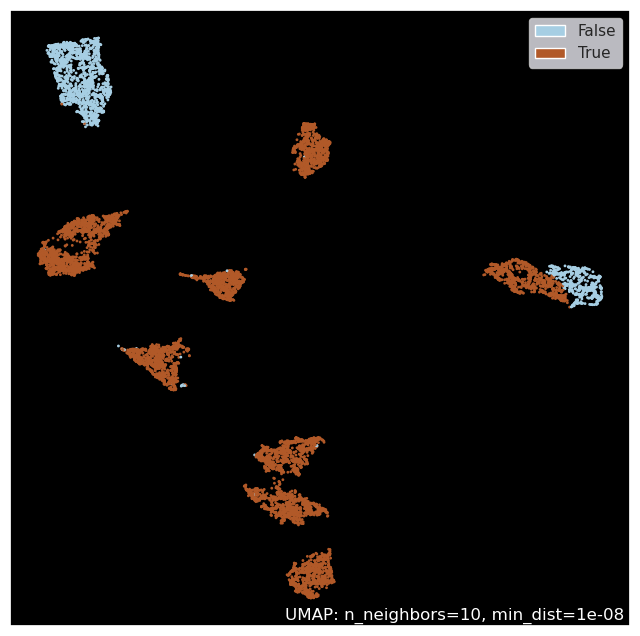

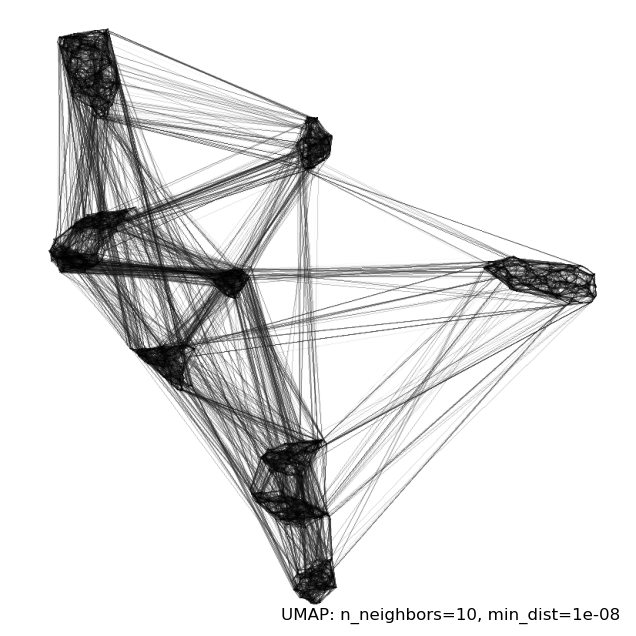

ValueError: need at least one array to concatenate

In [14]:
for dataset_id in range(5):
    G, umap_rep, clique_per_part, clique_summary, disagreement_labels = what_we_do_here(dataset_id, 1.0)
    sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
    plt.show()
    display(clique_per_part[:20])
    umap.plot.points(umap_rep, labels=disagreement_labels, color_key_cmap='Paired', background='black')
    plt.show()
    umap.plot.connectivity(umap_rep, labels=disagreement_labels, color_key_cmap='Paired')
    plt.show()

# Cliques in fuzzy intersection graph

In [42]:
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
for e in G.es:
    e["leiden_internal"] = (clustering_labels[e.target] == clustering_labels[e.source])

Ground truth: 
size =  21
q =  0.9494420801380001
Leiden partition: 
size =  49
q = 0.9579996944622434
-----------------------
ari = 0.7413482882183544
ami = 0.89578049953426


ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1       12           38           72           35            0   
1              1       17           34           64           31            0   
2              2       27           26           41           16            0   
3              2       30           25           44           21            1   
4              2       33           21           30           10            0   
5              3       14           36           54           19            0   
6              3       15           36           54           19            0   
7              4        6           49           94           46            0   
8              4       32           23           43           21            0   
9              5        0           72          122           38            0   
10             6        5           67           90           22            0   
11             6       42            2            1            0            0   
12             6       43            2            1            0            0   
13             6       48            1            0            0            0   
14             7       13           37           69           33            0   
15             7       16           35           65           31            0   
16             8        9           41           78           39            1   
17             8       23           31           57           27            0   
18             9       10           40           62           10            0   
19             9       20           32           50           12            0   
20            10        1           72          143           71            0   
21            11        4           72          131           47            0   
22            12        8           42           66           19            0   
23            12       24           29           43           15            0   
24            12       44            1            0            0            0   
25            13       25           29           52           24            0   
26            13       29           25           46           22            0   
27            13       34           18           33           16            0   
28            14        3           72          125           25            1   
29            15       18           34           55           22            1   
30            15       22           31           56           28            2   
31            15       39            6           10            7            2   
32            15       45            1            0            0            0   
33            16       26           28           41           13            0   
34            16       28           26           42           17            0   
35            16       35           17           26           11            1   
36            16       46            1            0            0            0   
37            17        7           42           69           29            3   
38            17       36           16           25           12            2   
39            17       38            9           14            7            1   
40            17       41            4            6            4            1   
41            17       47            1            0            0            0   
42            18       21           32           47           17            1   
43            18       31           24           38           14            0   
44            18       37           11           16            7            1   
45            18       40            5            8            5            1   
46            19        2           72          128           45            0   
47            20       11           38           67           29            0   
48            20       19          

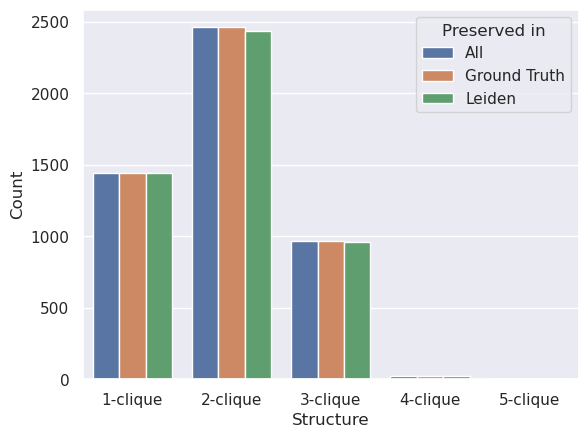

In [43]:
## q-based clustering
print('Ground truth: ')
print('size = ', max(targets)+1)
print('q = ',G.modularity(targets))
print('Leiden partition: ')
print('size = ', max(clustering_labels)+1)
print('q =',G.modularity(ec))
print('-----------------------')
print('ari =',adjusted_rand_score(targets,clustering_labels))
print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
clique_per_part

## Show disagreements

<AxesSubplot:>

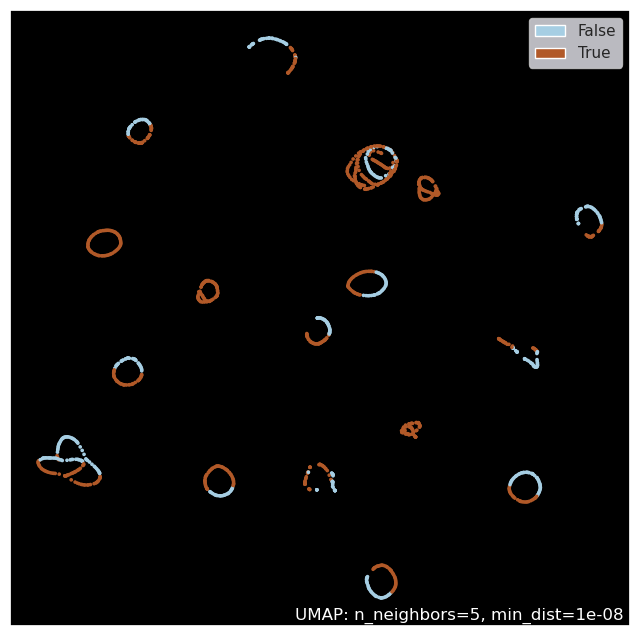

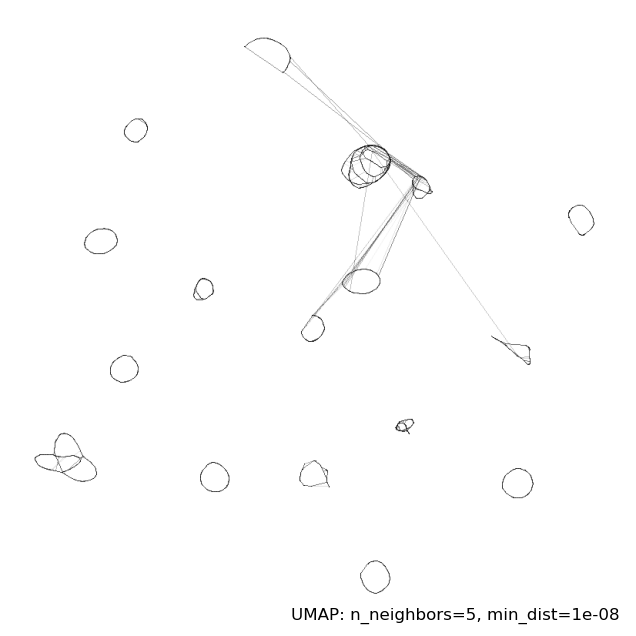

In [44]:
agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
present_gt = np.isin(targets, list(agree_cl_gt.ground_truth))
umap_rep = umap.UMAP(n_neighbors=5, n_components=2, min_dist=1e-8, random_state=0, n_epochs=1000).fit(raw_data)
umap.plot.points(umap_rep, labels=(agree_cl&present_gt), color_key_cmap='Paired', background='black')
umap.plot.connectivity(umap_rep, labels=(agree_cl&present_gt), color_key_cmap='Paired')

## pendigits

Ground truth: 
size =  10
q =  0.8797145712759515
Leiden partition: 
size =  27
q = 0.895541956249761
-----------------------
ari = 0.8517460969160207
ami = 0.8893509910441437


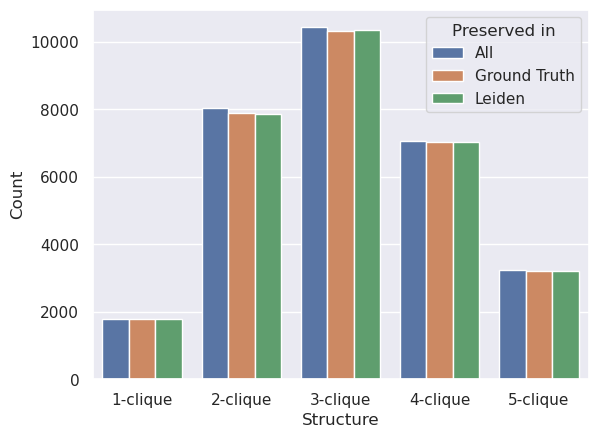

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        3          175          689          663          276   
1              0       17            2            1            0            0   
2              0       26            1            0            0            0   
3              1        9           87          375          527          385   
4              1       10           70          323          537          461   
5              1       13           28          143          322          406   
6              1       22            1            0            0            0   
7              2        5          166          801         1134          834   
8              2       15           10           31           53           56   
9              3        6          156          684          800          400   
10             3       18            1            0            0            0   
11             4        7          145          673          955          648   
12             4       12           29          120          197          173   
13             4       25            1            0            0            0   
14             5        1          178          825         1039          610   
15             6        2          178          820         1025          577   
16             6       16            2            1            0            0   
17             6       23            1            0            0            0   
18             7        4          166          738          948          626   
19             8        0          185          757          905          550   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0            52          178          690          663          276   
1             0          178          690          663          276   
2             0          178          690          663          276   
3           168          182          839         1381         1250   
4           228          182          839         1381         1250   
5           315          182          839         1381         1250   
6             0          182          839         1381         1250   
7           421          177          840         1195          894   
8            36          177          840         1195          894   
9            95          183          773          911          479   
10            0          183          773          911          479   
11          264          181          820         1174          828   
12           85          181          820         1174          828   
13            0          181          820         1174          828   
14          191          182          830         1043          611   
15          188          181          820         1023          576   
16            0          181          820         1023          576   
17            0          181          820         1023          576   
18          249          179          794         1063          775   
19          194          174          711          872          543   

    5-clique_gt  
0            52  
1            52  
2            52  
3           711  
4           711  
5           711  
6           711  
7           458  
8           458  
9           124  
10          124  
11          350  
12          350  
13          350  
14          191  
15          188  
16          188  
17          188  
18          371  
19          193

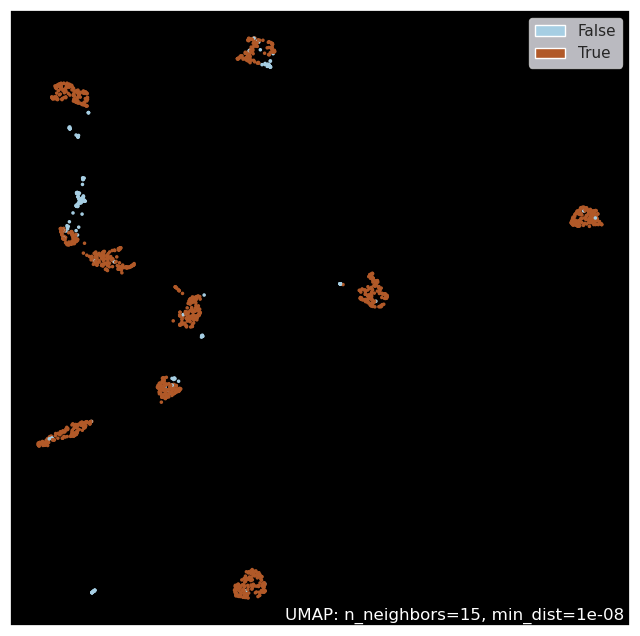

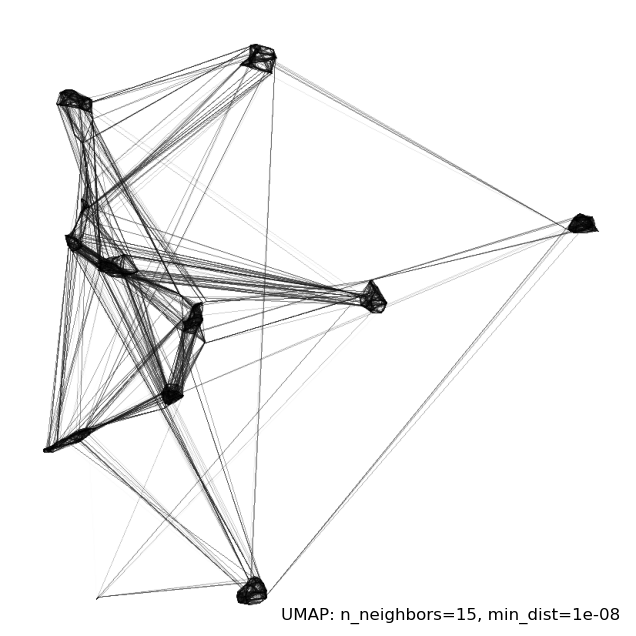

## coil

Ground truth: 
size =  21
q =  0.9494420801380001
Leiden partition: 
size =  49
q = 0.9580198216794545
-----------------------
ari = 0.741160524768101
ami = 0.8957387617027837


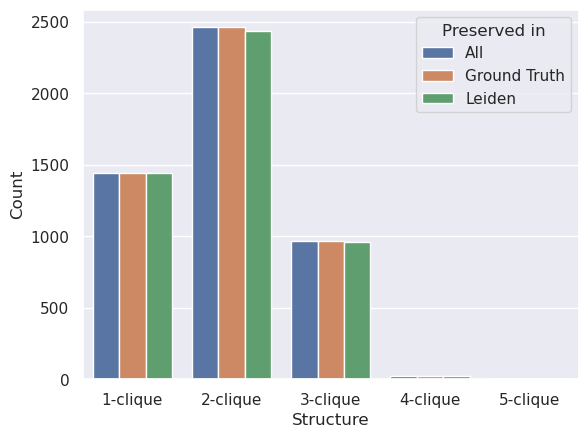

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1       10           38           72           35            0   
1              1       20           34           64           31            0   
2              2       29           25           39           16            1   
3              2       30           25           40           16            0   
4              2       33           22           36           15            0   
5              3       12           38           58           21            0   
6              3       17           34           50           17            0   
7              4        6           49           94           46            0   
8              4       32           23           43           21            0   
9              5        1           72          122           38            0   
10             6        5           67           90           22            0   
11             6       42            2            1            0            0   
12             6       43            2            1            0            0   
13             6       48            1            0            0            0   
14             7       14           37           69           33            0   
15             7       15           35           65           31            0   
16             8        9           41           78           39            1   
17             8       23           31           57           27            0   
18             9       11           38           59           10            0   
19             9       16           34           53           12            0   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             0           72          139           67            0   
1             0           72          139           67            0   
2             0           72          118           47            1   
3             0           72          118           47            1   
4             0           72          118           47            1   
5             0           72          110           38            0   
6             0           72          110           38            0   
7             0           72          140           68            0   
8             0           72          140           68            0   
9             0           72          122           38            0   
10            0           72           92           22            0   
11            0           72           92           22            0   
12            0           72           92           22            0   
13            0           72           92           22            0   
14            0           72          137           65            0   
15            0           72          137           65            0   
16            0           72          138           67            1   
17            0           72          138           67            1   
18            0           72          114           22            0   
19            0           72          114           22            0   

    5-clique_gt  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11            0  
12            0  
13            0  
14            0  
15            0  
16            0  
17            0  
18            0  
19            0

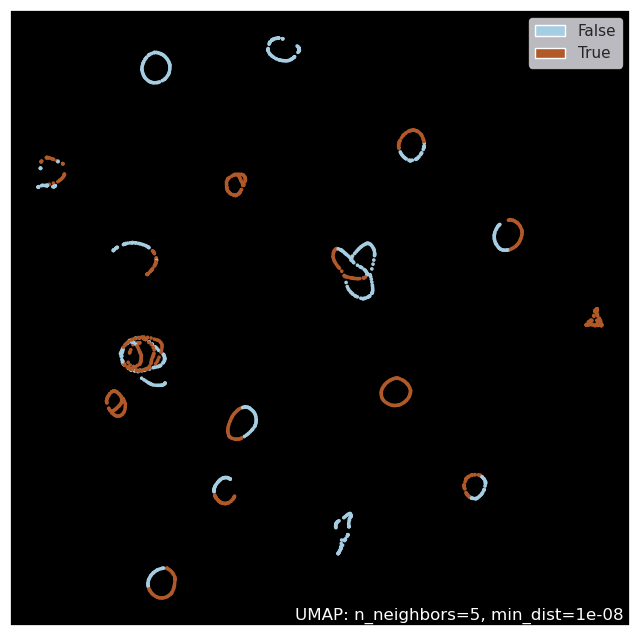

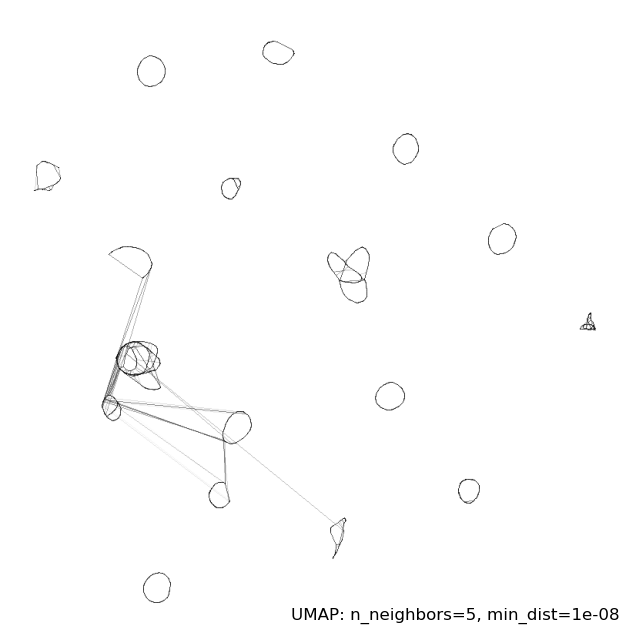

## mnist

Ground truth: 
size =  10
q =  0.8793361577356662
Leiden partition: 
size =  1968
q = 0.91502610778247
-----------------------
ari = 0.5150715866437827
ami = 0.702313724507599


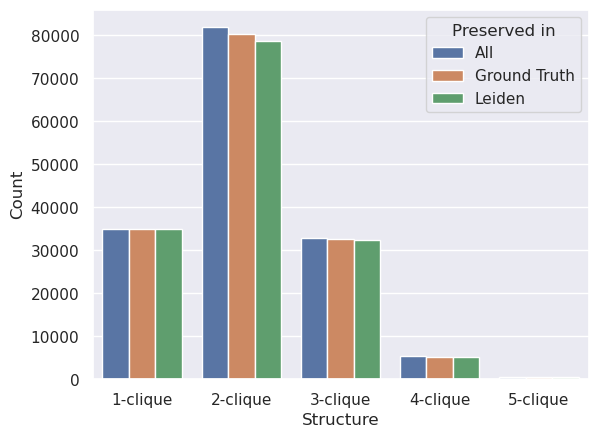

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        7         1634         3967         1719          259   
1              0        9         1478         3719         1581          235   
2              0       29           13           14            1            0   
3              0       31            6            7            2            0   
4              0       41            4            3            0            0   
5              0       58            3            2            0            0   
6              0       60            3            2            0            0   
7              0       68            3            2            0            0   
8              0       82            2            1            0            0   
9              0       87            2            1            0            0   
10             0       95            2            1            0            0   
11             0      111            2            1            0            0   
12             0      115            2            1            0            0   
13             0      116            2            1            0            0   
14             0      133            2            1            0            0   
15             0      139            2            1            0            0   
16             0      146            2            1            0            0   
17             0      148            2            1            0            0   
18             0      163            2            1            0            0   
19             0      166            2            1            0            0   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0            13         3434         8062         3398          505   
1            12         3434         8062         3398          505   
2             0         3434         8062         3398          505   
3             0         3434         8062         3398          505   
4             0         3434         8062         3398          505   
5             0         3434         8062         3398          505   
6             0         3434         8062         3398          505   
7             0         3434         8062         3398          505   
8             0         3434         8062         3398          505   
9             0         3434         8062         3398          505   
10            0         3434         8062         3398          505   
11            0         3434         8062         3398          505   
12            0         3434         8062         3398          505   
13            0         3434         8062         3398          505   
14            0         3434         8062         3398          505   
15            0         3434         8062         3398          505   
16            0         3434         8062         3398          505   
17            0         3434         8062         3398          505   
18            0         3434         8062         3398          505   
19            0         3434         8062         3398          505   

    5-clique_gt  
0            26  
1            26  
2            26  
3            26  
4            26  
5            26  
6            26  
7            26  
8            26  
9            26  
10           26  
11           26  
12           26  
13           26  
14           26  
15           26  
16           26  
17           26  
18           26  
19           26

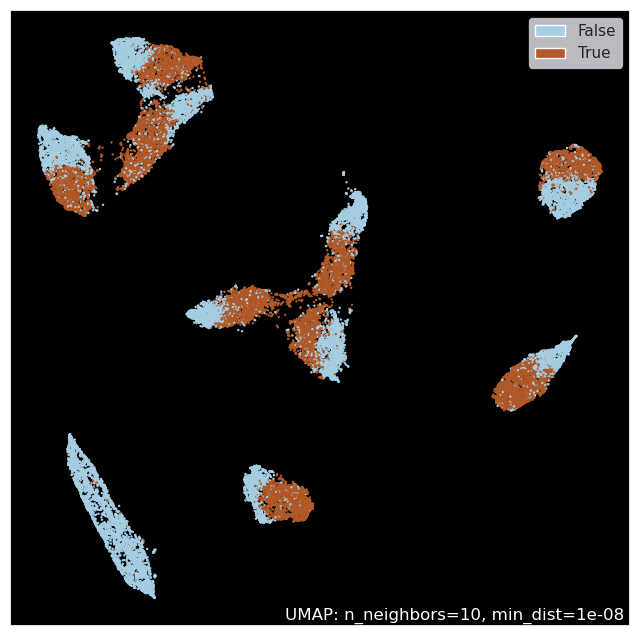

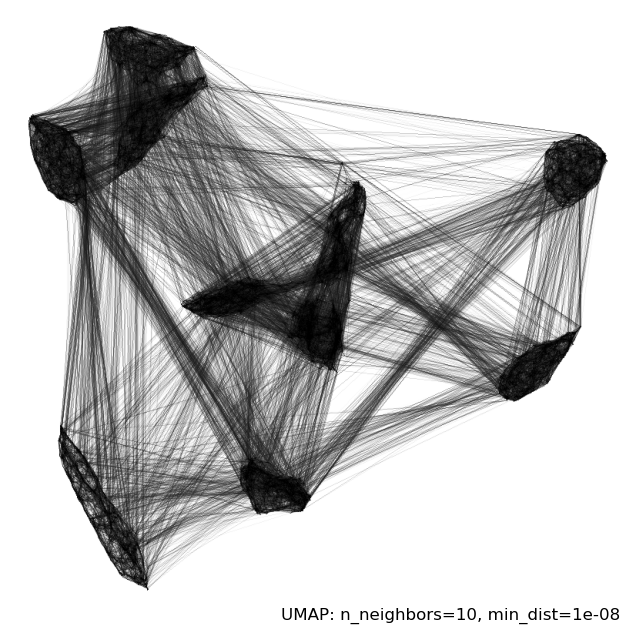

## usps

Ground truth: 
size =  11
q =  0.8757991636557155
Leiden partition: 
size =  531
q = 0.9108927935609225
-----------------------
ari = 0.5291796491211558
ami = 0.7213085891725146


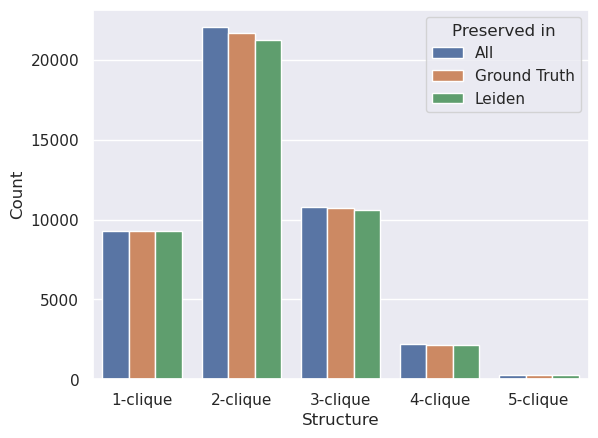

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        9          416         1021          472           82   
1              1       10          406         1035          569          113   
2              1       12          345          732          295           45   
3              1       14          254          628          371          121   
4              1       32            5            5            1            0   
5              1       33            4            4            1            0   
6              1       36            3            3            1            0   
7              1       38            3            2            0            0   
8              1       41            3            2            0            0   
9              1       48            2            1            0            0   
10             1       50            2            1            0            0   
11             1       55            2            1            0            0   
12             1       58            2            1            0            0   
13             1       61            2            1            0            0   
14             1       65            2            1            0            0   
15             1       72            2            1            0            0   
16             1       74            2            1            0            0   
17             1       76            2            1            0            0   
18             1       79            2            1            0            0   
19             1       81            2            1            0            0   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             8         1553         3613         1759          363   
1            10         1553         3613         1759          363   
2             3         1553         3613         1759          363   
3            27         1553         3613         1759          363   
4             0         1553         3613         1759          363   
5             0         1553         3613         1759          363   
6             0         1553         3613         1759          363   
7             0         1553         3613         1759          363   
8             0         1553         3613         1759          363   
9             0         1553         3613         1759          363   
10            0         1553         3613         1759          363   
11            0         1553         3613         1759          363   
12            0         1553         3613         1759          363   
13            0         1553         3613         1759          363   
14            0         1553         3613         1759          363   
15            0         1553         3613         1759          363   
16            0         1553         3613         1759          363   
17            0         1553         3613         1759          363   
18            0         1553         3613         1759          363   
19            0         1553         3613         1759          363   

    5-clique_gt  
0            48  
1            48  
2            48  
3            48  
4            48  
5            48  
6            48  
7            48  
8            48  
9            48  
10           48  
11           48  
12           48  
13           48  
14           48  
15           48  
16           48  
17           48  
18           48  
19           48

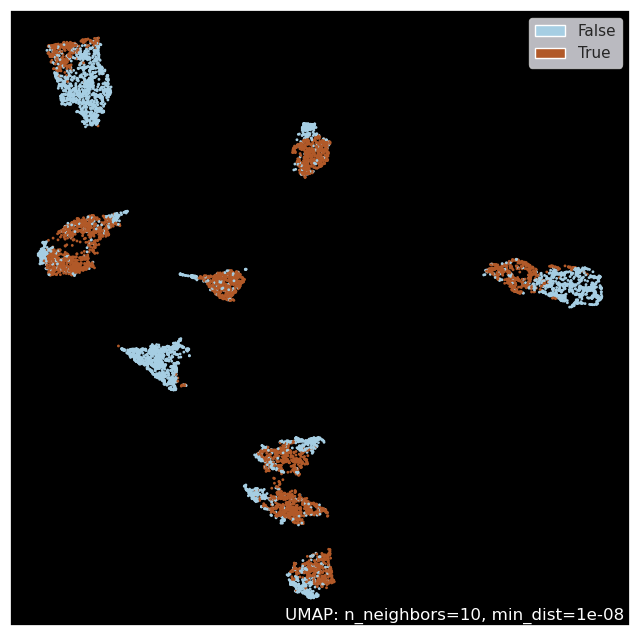

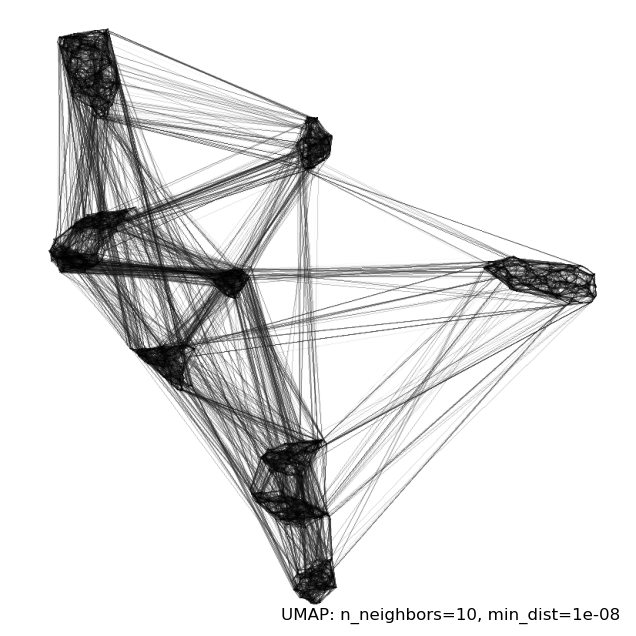

## buildings

Ground truth: 
size =  41
q =  0.947122418266131
Leiden partition: 
size =  422
q = 0.9860254260687212
-----------------------
ari = 0.36468128337432676
ami = 0.720686660639103


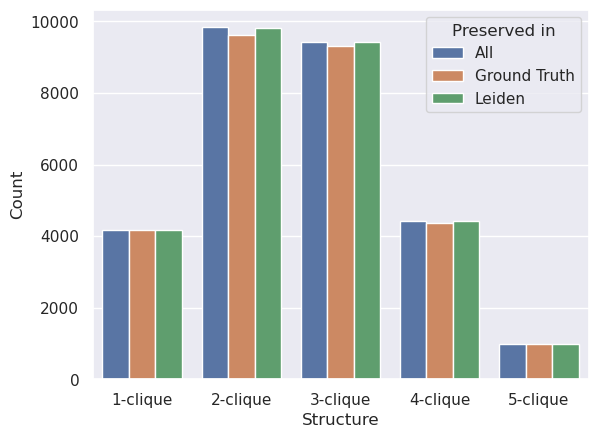

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        0          100          296          226           50   
1              1        2           82          231          180           48   
2              1       19           46          108          102           57   
3              1       20           45          101           83           29   
4              1       34           36          102          117           69   
5              1       54           27           72           71           33   
6              1      122            6            8            3            0   
7              1      220            1            0            0            0   
8              1      221            1            0            0            0   
9              1      222            1            0            0            0   
10             1      223            1            0            0            0   
11             1      224            1            0            0            0   
12             1      225            1            0            0            0   
13             1      226            1            0            0            0   
14             1      227            1            0            0            0   
15             1      228            1            0            0            0   
16             1      229            1            0            0            0   
17             1      230            1            0            0            0   
18             1      231            1            0            0            0   
19             2       45           32           99          123           75   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             4          334          861          735          268   
1             2          334          861          735          268   
2            19          334          861          735          268   
3             4          334          861          735          268   
4            22          334          861          735          268   
5             8          334          861          735          268   
6             0          334          861          735          268   
7             0          334          861          735          268   
8             0          334          861          735          268   
9             0          334          861          735          268   
10            0          334          861          735          268   
11            0          334          861          735          268   
12            0          334          861          735          268   
13            0          334          861          735          268   
14            0          334          861          735          268   
15            0          334          861          735          268   
16            0          334          861          735          268   
17            0          334          861          735          268   
18            0          334          861          735          268   
19           23          112          285          312          181   

    5-clique_gt  
0            56  
1            56  
2            56  
3            56  
4            56  
5            56  
6            56  
7            56  
8            56  
9            56  
10           56  
11           56  
12           56  
13           56  
14           56  
15           56  
16           56  
17           56  
18           56  
19           53

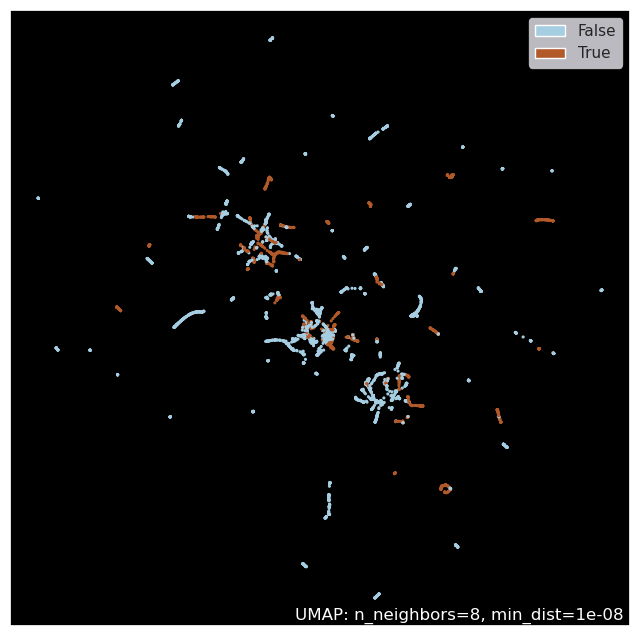

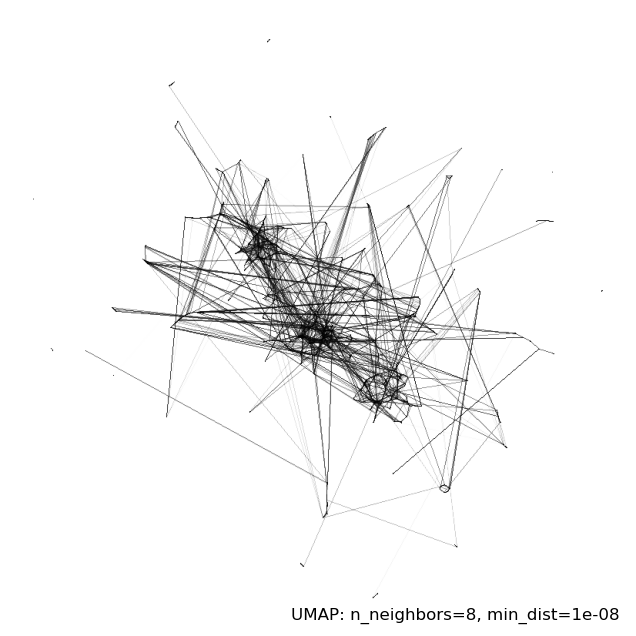

In [28]:
for dataset_id in range(5):
    G, umap_rep, clique_per_part, clique_summary, disagreement_labels = what_we_do_here(dataset_id, 0.0)
    sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
    plt.show()
    display(clique_per_part[:20])
    umap.plot.points(umap_rep, labels=disagreement_labels, color_key_cmap='Paired', background='black')
    plt.show()
    umap.plot.connectivity(umap_rep, labels=disagreement_labels, color_key_cmap='Paired')
    plt.show()

# Cliques in k-NN - low dimensional

We have seen that the partition of the following "UMAP graph + Leiden" pipeline is preserving more cliques then the groundtruth partition is. Let's call this partition, partiton A. Here, we want to know if the groundtruth is preserving more of the low dimensional structure then partition A. That is, we will construct the UMAP graph of the projected data and look at how many cliques are preserved by the groundtruth compare to the number of cliques preserved by A.

From our experiment, the same observation holds: A preserves more of the low dimensional neighborhood structure than the ground truth does, on all datasets.

In [17]:
def cliques_in_knn_low(dataset_id, set_op_mix_ratio, verbose=True):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    
    # Here we are computing the UMAP graph on the low dimensional embedding
    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    G_umap = get_umap_graph(umap_rep, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    
    ec = la.find_partition(G, la.ModularityVertexPartition)
    clustering_labels = np.array(ec.membership)
    G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')
    
    ## q-based clustering
    if(verbose):
        print('Ground truth: ')
        print('size = ', max(targets)+1)
        print('q = ',G.modularity(targets))
        print('Leiden partition: ')
        print('size = ', max(clustering_labels)+1)
        print('q =',G.modularity(ec))
        print('-----------------------')
        print('ari =',adjusted_rand_score(targets,clustering_labels))
        print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

    clique_per_part, clique_summary = clique_preservation(G_umap, targets, clustering_labels)

    return(clique_per_part, clique_summary)

## pendigits

Ground truth: 
size =  10
q =  0.8424726535927892
Leiden partition: 
size =  12
q = 0.8602168856380311
-----------------------
ari = 0.8860811639724393
ami = 0.9067286171175399


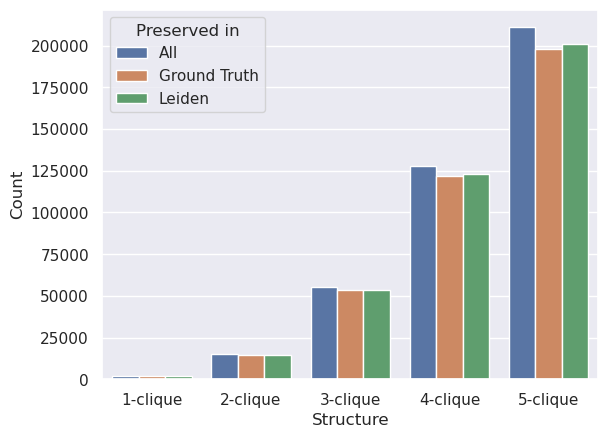

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             0        4          178         1497         5035         9937   
1             1        9          104          844         3328         8241   
2             1       10           80          633         2612         6948   
3             1       11           27          235         1118         3476   
4             2        7          167         1413         5314        12388   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0        13151          178         1497         5035         9937   
1        14485          182         1513         6047        15307   
2        13362          182         1513         6047        15307   
3         7690          182         1513         6047        15307   
4        20412          177         1458         5434        12598   

   5-clique_gt  
0        13151  
1        27649  
2        27649  
3        27649  
4        20664

## coil

Ground truth: 
size =  21
q =  0.8945446658779549
Leiden partition: 
size =  28
q = 0.9325189182410571
-----------------------
ari = 0.743189094351226
ami = 0.8752937827047246


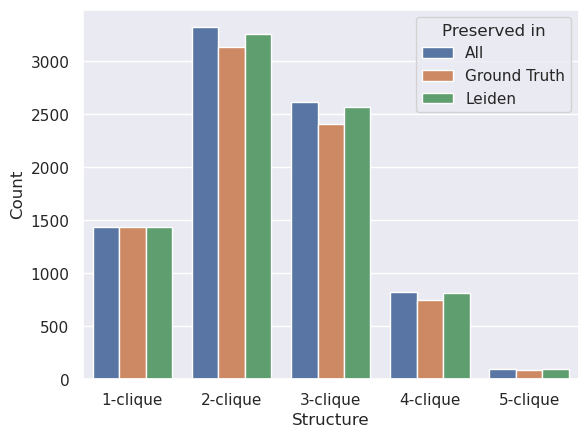

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             1        1           72          159          119           34   
1             2        9           69          156          121           35   
2             2       22           29           64           45            9   
3             3       26           19           41           29            6   
4             4        4           72          158          104           19   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0            4           72          159          119           34   
1            2           72          155          107           23   
2            0           72          155          107           23   
3            0           72          138          101           30   
4            1           72          158          104           19   

   5-clique_gt  
0            4  
1            0  
2            0  
3            3  
4            1

## mnist

Ground truth: 
size =  10
q =  0.828038492552303
Leiden partition: 
size =  13
q = 0.8582372946518656
-----------------------
ari = 0.8253552100775681
ami = 0.8507714395271939


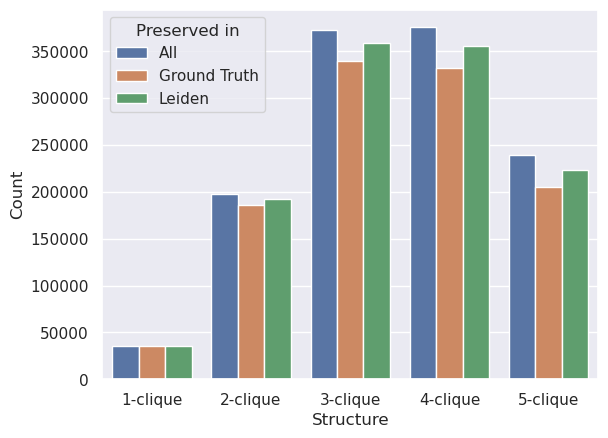

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             0        3         3496        19269        35624        34739   
1             1        8         2445        13522        27232        30660   
2             1       10         1793         9805        20520        24057   
3             2        4         3292        18314        33595        32928   
4             3        1         3555        19698        35495        33493   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0        21258         3434        18604        33798        32396   
1        22188         4002        21682        43093        47791   
2        18003         4002        21682        43093        47791   
3        20539         3434        18322        33441        32787   
4        19596         3576        18925        33910        31998   

   5-clique_gt  
0        19431  
1        33920  
2        33920  
3        20577  
4        18781

## usps

Ground truth: 
size =  11
q =  0.8283499377845813
Leiden partition: 
size =  12
q = 0.8608554411175516
-----------------------
ari = 0.8098283277522101
ami = 0.8731709436837666


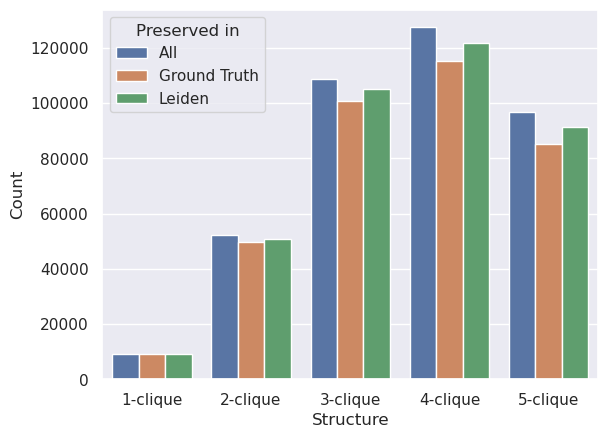

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             1        6          808         4347         8813        10037   
1             1        8          776         4172         8266         8996   
2             2        0          918         5013        10957        13775   
3             2       11          360         1916         4143         5109   
4             3        1          903         4880        10070        11723   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0         7359         1553         8422        16750        18405   
1         6214         1553         8422        16750        18405   
2        11293         1269         6912        14985        18498   
3         4084         1269         6912        14985        18498   
4         8745          929         4854        10006        11677   

   5-clique_gt  
0        12838  
1        12838  
2        14759  
3        14759  
4         8752

## buildings

Ground truth: 
size =  41
q =  0.7278299373437985
Leiden partition: 
size =  56
q = 0.8965380537932027
-----------------------
ari = 0.28626856489792146
ami = 0.6027710171008428


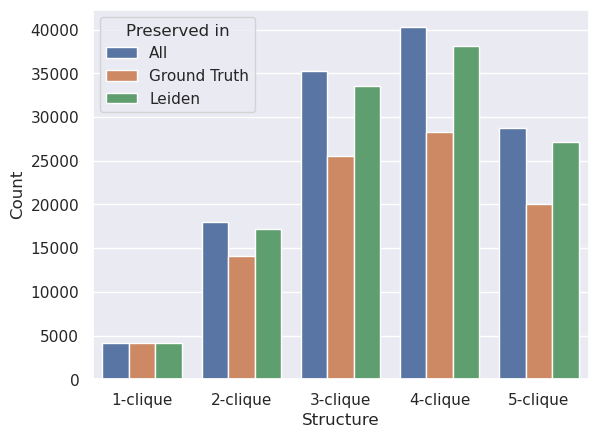

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             1        4          169          661         1142         1111   
1             1       19           82          356          631          606   
2             1       37           39          155          307          359   
3             2       21           81          341          678          786   
4             2       47           26          111          243          315   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0          658          334         1135         1836         1738   
1          356          334         1135         1836         1738   
2          262          334         1135         1836         1738   
3          569          112          448          905         1098   
4          253          112          448          905         1098   

   5-clique_gt  
0         1038  
1         1038  
2         1038  
3          846  
4          846

In [37]:
for dataset_id in [0,1,2,3,4]:
    clique_per_part, clique_summary = cliques_in_knn_low(dataset_id, 1.0)
    sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
    plt.show()
    display(clique_per_part[:5])

## View images in cliques maintained by graph clustering

We want to understand what are the cliques that are preserved by Leiden on UMAP graph that are not preserved by the UMAP+HDBSCAN pipeline - and the other way around.

In [86]:
def list_clique_per_cluster(G, clustering_labels, x):
    cliques_part = []
    G.vs['name'] = range(G.vcount())
    for d in range(np.max(clustering_labels)+1):
        sg = G.subgraph([i for i in range(G.vcount()) if clustering_labels[i]==d])
        cliques_part = cliques_part+[tuple([sg.vs[i]['name'] for i in x]) for x in sg.cliques(min=x,max=x)]
    return(cliques_part)

# Pendigit

In [190]:
dataset_id = 0
set_op_mix_ratio = 1
raw_data, targets, dataset_name, image_list = get_dataset(dataset_id, return_images=True)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)

In [193]:
cliques_from_clust = list_clique_per_cluster(G, clustering_labels, 3)
cliques_from_true = list_clique_per_cluster(G, targets, 3)
extra_cliques = list(set.difference(set(cliques_from_clust), set(cliques_from_true)))

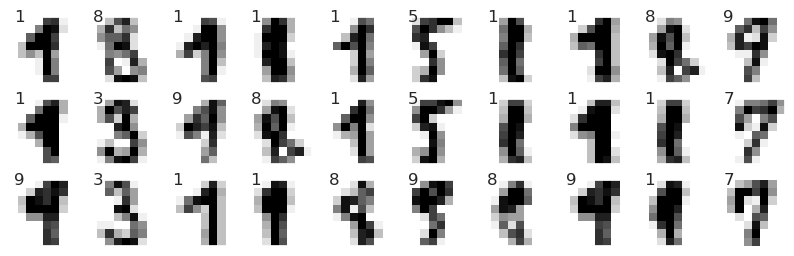

In [198]:
N = 10
fig, axs = plt.subplots(3, N, figsize=(N,3))
#fig.suptitle('Extra triangles preserved by clustering')
for j, example in enumerate(extra_cliques[0:N]):
    for i in range(3):
        plt.axis('off')
        axs[i, j].imshow(16- image_list[example[i]], cmap='gray', vmin=0, vmax=16)
        axs[i, j].text(0,0,str(targets[example[i]]))
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
plt.savefig('figures/extra_triangles_pendigit.png', bbox_inches='tight')

In [205]:
# example = extra_cliques[6]
# fig, axs = plt.subplots(2, 2)
# fig.suptitle('One four clique')
# for i in range(3):
#     plt.axis('off')
#     axs[i//2, i%2].imshow(16- image_list[example[i]], cmap='gray', vmin=0, vmax=16)
#     axs[i//2, i%2].text(0,0,str(targets[example[i]]))
#     axs[i//2, i%2].get_xaxis().set_visible(False)
#     axs[i//2, i%2].get_yaxis().set_visible(False)

# Coil

In [517]:
dataset_id = 1
set_op_mix_ratio = 1
raw_data, targets, dataset_name, image_list = get_dataset(dataset_id, return_images=True)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)

umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)

In [518]:
pattern = 3
N = 10

In [519]:
cliques_from_clust = list_clique_per_cluster(G, clustering_labels, pattern)
cliques_from_hdbscan = list_clique_per_cluster(G, hd_umap_labels, pattern)
cliques_from_true = list_clique_per_cluster(G, targets, pattern)
extra_cliques = list(set.difference(set.difference(set(cliques_from_clust), set(cliques_from_true)), set(cliques_from_hdbscan)))
len(extra_cliques)

10

In [520]:
candidates = extra_cliques

In [521]:
candidates[0]

(654, 1124, 1125)

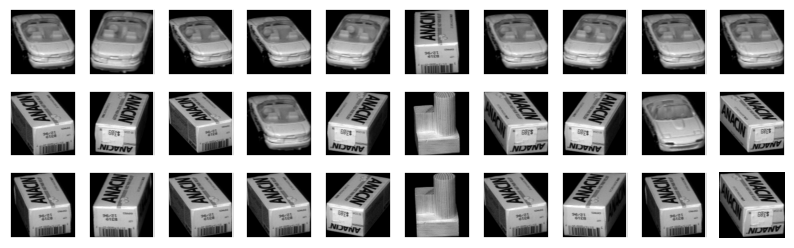

In [435]:
# COIL
N = min(N, len(candidates))
fig, axs = plt.subplots(pattern, N, figsize=(N,pattern))
#fig.suptitle('Extra triangles preserved by clustering')
for j, example in enumerate(candidates[0:N]):
    for i in range(pattern):
        plt.axis('off')
        axs[i, j].imshow(image_list[example[i]], cmap='gray')
        # axs[i, j].text(0,0,str(targets[example[i]]-1))
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
plt.savefig('figures/extra_triangles_coil_error_graph.png', bbox_inches='tight')

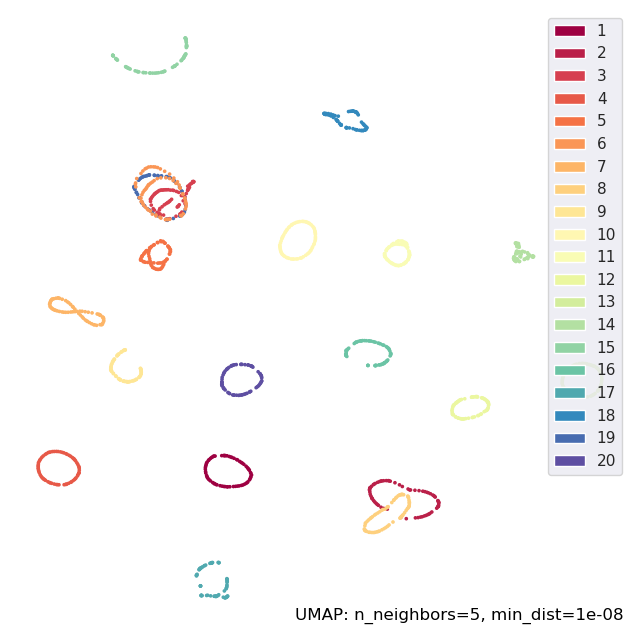

In [523]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2, return_vectors=False)
umap.plot.points(umap_rep, labels=targets)
plt.show()

In [525]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2, return_vectors=False)

In [565]:
x = [umap_rep.embedding_[i, 0] for triangle in range(10) for i in candidates[triangle]]
y = [umap_rep.embedding_[i, 1] for triangle in range(10) for i in candidates[triangle]]
labels = [f'Group {triangle}' for triangle in range(10) for i in candidates[triangle]]

In [566]:
x

[-4.0144567,
 -5.0867333,
 -4.990575,
 -2.9324832,
 -5.2467756,
 -5.203787,
 -4.0774627,
 -5.219034,
 -5.0867333,
 -4.0774627,
 -4.0144567,
 -5.0867333,
 -2.6995208,
 -5.346676,
 -5.5139737,
 -5.02245,
 -3.8452575,
 -3.883399,
 -4.0144567,
 -5.051457,
 -5.0867333,
 -2.6995208,
 -5.346676,
 -5.319075,
 -4.0144567,
 -3.9494014,
 -4.990575,
 -4.0144567,
 -5.2041845,
 -5.051457]

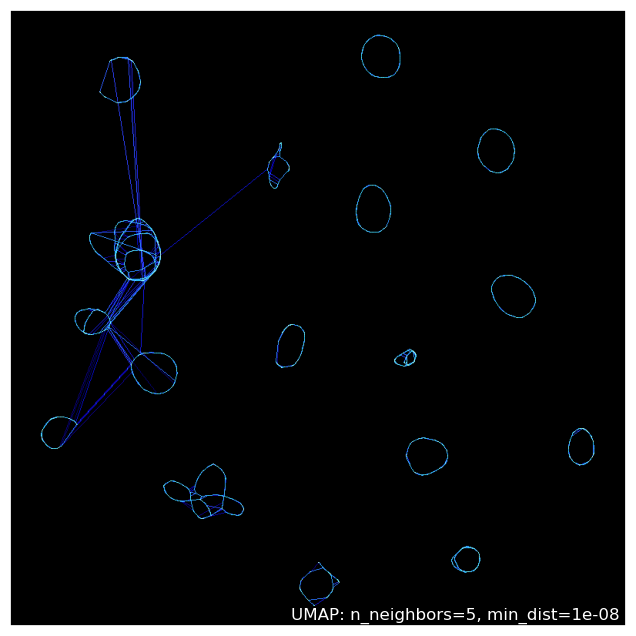

In [576]:
umap.plot.connectivity(umap_rep, theme='darkred')
plt.savefig('figures/extra_triangles_coil_umap_connectivity.png', bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


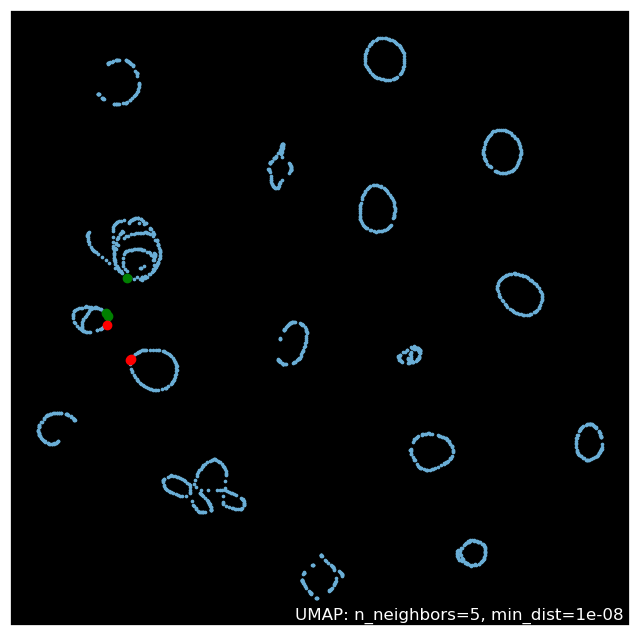

In [578]:
umap.plot.points(umap_rep, background='black')
triangle = 0
plt.scatter(x=[umap_rep.embedding_[i, 0] for i in candidates[triangle]], y=[umap_rep.embedding_[i, 1] for i in candidates[triangle]], c='green')
triangle = 5
plt.scatter(x=[umap_rep.embedding_[i, 0] for i in candidates[triangle]], y=[umap_rep.embedding_[i, 1] for i in candidates[triangle]], c='red')
#  plt.scatter(x=x, y=y, )
plt.savefig('figures/extra_triangles_coil_umap_effect.png', bbox_inches='tight')
plt.show()


In [437]:
extra_cliques = list(set.difference(set.difference(set(cliques_from_hdbscan), set(cliques_from_true)), set(cliques_from_clust)))
len(extra_cliques)

1

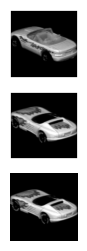

In [440]:
# COIL
candidates = extra_cliques
N = min(N, len(candidates))
fig, axs = plt.subplots(pattern, figsize=(N,pattern))
#fig.suptitle('Extra triangles preserved by clustering')
for i in range(pattern):
    plt.axis('off')
    axs[i].imshow(image_list[example[i]], cmap='gray')
    # axs[i, j].text(0,0,str(targets[example[i]]-1))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.savefig('figures/extra_triangles_coil_error_hdbscan.png', bbox_inches='tight')

# MNIST

In [466]:
dataset_id = 2
set_op_mix_ratio = 1
raw_data, targets, dataset_name, image_list = get_dataset(dataset_id, return_images=True)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)

umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)

In [467]:
pattern = 5
N = 10

In [ ]:
cliques_from_clust = list_clique_per_cluster(G, clustering_labels, pattern)
cliques_from_hdbscan = list_clique_per_cluster(G, hd_umap_labels, pattern)
cliques_from_true = list_clique_per_cluster(G, targets, pattern)

In [478]:
extra_cliques = list(set.difference(set.difference(set(cliques_from_clust), set(cliques_from_true)), set(cliques_from_hdbscan)))
len(extra_cliques)

90

In [479]:
from collections import Counter
candidates = []
for i in range(len(extra_cliques)):
    if min(list(Counter([targets[x] for x in extra_cliques[i]]).values()))>1:
        candidates.append(extra_cliques[i])
len(candidates)

14

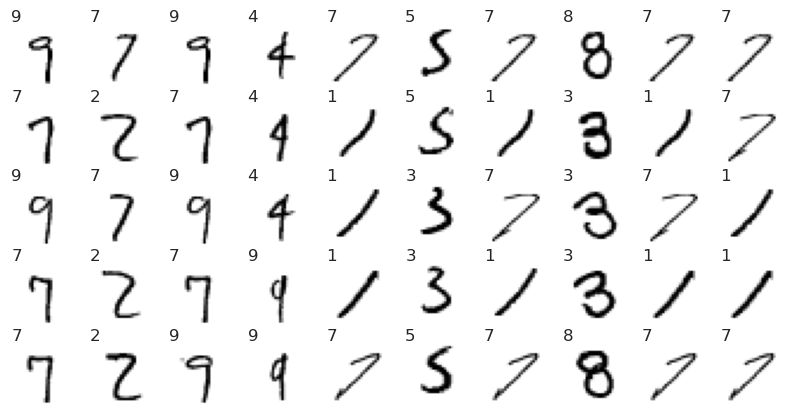

In [480]:
# candidates = extra_cliques
N = min(N, len(candidates))
fig, axs = plt.subplots(pattern, N, figsize=(N,pattern))
#fig.suptitle('Extra triangles preserved by clustering')
for j, example in enumerate(candidates[0:N]):
    for i in range(pattern):
        plt.axis('off')
        axs[i, j].imshow(image_list[example[i]], cmap='gray')
        axs[i, j].text(0,0,str(targets[example[i]]))
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
plt.savefig('figures/extra_triangles_mnist_error_graph.png', bbox_inches='tight')

In [481]:
extra_cliques = list(set.difference(set.difference(set(cliques_from_hdbscan), set(cliques_from_true)), set(cliques_from_clust)))
len(extra_cliques)

13

In [485]:
from collections import Counter
candidates = []
for i in range(len(extra_cliques)):
    if min(list(Counter([targets[x] for x in extra_cliques[i]]).values()))>1:
        candidates.append(extra_cliques[i])
len(candidates)

2

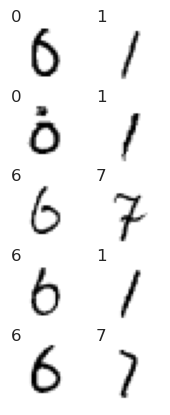

In [486]:
# candidates = extra_cliques
N = min(N, len(candidates))
fig, axs = plt.subplots(pattern, N, figsize=(N,pattern))
#fig.suptitle('Extra triangles preserved by clustering')
for j, example in enumerate(candidates[0:N]):
    for i in range(pattern):
        plt.axis('off')
        axs[i, j].imshow(image_list[example[i]], cmap='gray')
        axs[i, j].text(0,0,str(targets[example[i]]))
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
plt.savefig('figures/extra_triangles_mnist_error_hdbscan.png', bbox_inches='tight')

# USPS

In [579]:
dataset_id = 3
raw_data, targets, dataset_name, image_list = get_dataset(dataset_id, return_images=True)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)

umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)

In [581]:
KK = G.ecount()

In [ ]:
0.41, 0.44, 0.3, 0.29, 0.48

In [588]:
dataset_id = 4
raw_data, targets, dataset_name, image_list = get_dataset(dataset_id, return_images=True)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G.transitivity_undirected()

0.47682053975966904

In [405]:
pattern = 4
N = 10

In [406]:
cliques_from_clust = list_clique_per_cluster(G, clustering_labels, pattern)
cliques_from_hdbscan = list_clique_per_cluster(G, hd_umap_labels, pattern)
cliques_from_true = list_clique_per_cluster(G, targets, pattern)
extra_cliques = list(set.difference(set.difference(set(cliques_from_clust), set(cliques_from_true)), set(cliques_from_hdbscan)))
len(extra_cliques)

177

In [411]:
extra_cliques = list(set.difference(set.difference(set(cliques_from_hdbscan), set(cliques_from_true)), set(cliques_from_clust)))
len(extra_cliques)

95

In [412]:
from collections import Counter
candidates = []
for i in range(len(extra_cliques)):
    if min(list(Counter([targets[x] for x in extra_cliques[i]]).values()))>1:
        candidates.append(extra_cliques[i])
len(candidates)

26

In [413]:
N = min(N, len(candidates))

In [ ]:
candidates

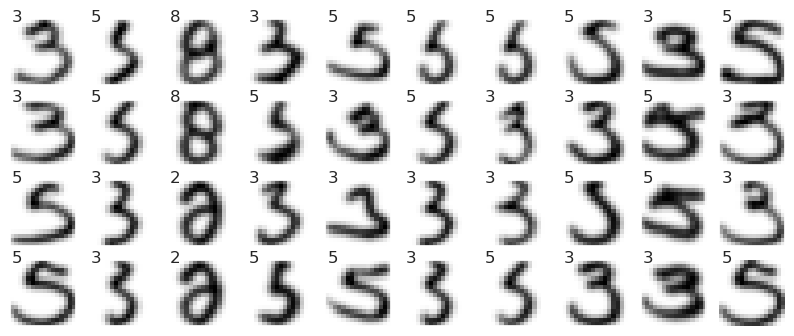

In [414]:
fig, axs = plt.subplots(pattern, N, figsize=(N,pattern))
#fig.suptitle('Extra triangles preserved by clustering')
for j, example in enumerate(candidates[0:N]):
    for i in range(pattern):
        plt.axis('off')
        axs[i, j].imshow(image_list[example[i]], cmap='gray')
        axs[i, j].text(0,0,str(targets[example[i]]-1))
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
plt.savefig('figures/extra_triangles_usps_hdbscan_error.png', bbox_inches='tight')

# Buildings

In [338]:
dataset_id = 4
raw_data, targets, dataset_name, image_list = get_dataset(dataset_id, return_images=True)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)

In [346]:
pattern = 4
N = 10

In [347]:
cliques_from_clust = list_clique_per_cluster(G, clustering_labels, pattern)
cliques_from_true = list_clique_per_cluster(G, targets, pattern)
extra_cliques = list(set.difference(set(cliques_from_clust), set(cliques_from_true)))
N = min(N, len(extra_cliques))
len(extra_cliques)

4649

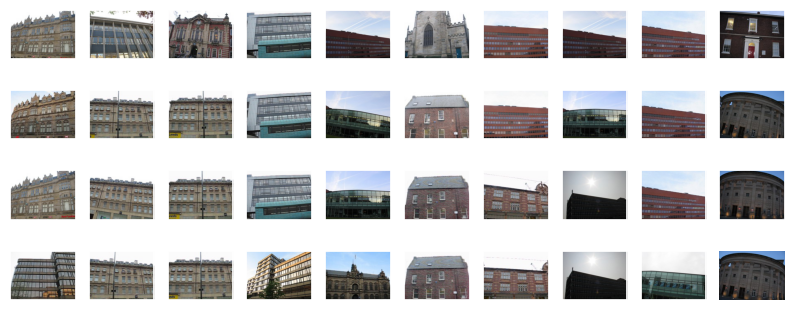

In [348]:
fig, axs = plt.subplots(pattern, N, figsize=(N,pattern))
#fig.suptitle('Extra triangles preserved by clustering')
for j, example in enumerate(extra_cliques[0:N]):
    for i in range(pattern):
        plt.axis('off')
        axs[i, j].imshow(np.asarray(image_list[example[i]]))
        # axs[i, j].text(0,0,str(targets[example[i]]))
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
plt.savefig('figures/extra_triangles_buildings.png', bbox_inches='tight')